In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

#This is required if you have never used nltk before
#nltk.download()

In [2]:
#Read CSV and add additional data columns

df = pd.read_csv('usg_comments_short.csv')
df = df[(df.ndate > 20180300) & (df.ndate < 20180417)]
df['nh'] = df.groupby(['ndate','trk','meet','race'])['fin'].transform('count')
df['nfin'] = 0.5 - (df['fin'] - 1.0) / (df['nh'] - 1.0)

In [3]:
#Inspect the data

df[['ndate','trk','meet','race','nh','fin','nfin','com']]

,ndate,trk,meet,race,nh,fin,nfin,com
0,20180301,DB,A,1,8,1,0.500000,FINAL STRIDE INSD
1,20180301,DB,A,1,8,2,0.357143,OUTNODDED RL
2,20180301,DB,A,1,8,3,0.214286,DISTANT SHOW RL
3,20180301,DB,A,1,8,4,0.071429,CLOSED GROUND RL
4,20180301,DB,A,1,8,5,-0.071429,STEADY GAIN INSD
5,20180301,DB,A,1,8,6,-0.214286,VARIED LITTLE INSD
6,20180301,DB,A,1,8,7,-0.357143,TIRED STRETCH
7,20180301,DB,A,1,8,8,-0.500000,GAVE WAY STRETCH
8,20180301,DB,A,2,8,1,0.500000,FINAL STRIDE RKL
9,20180301,DB,A,2,8,2,0.357143,IN HOT PURSUIT INSD


In [4]:
#Clean comments

stop = stopwords.words('english')
st = PorterStemmer()

df['com_np'] = df['com'].str.replace('[^\w\s]','')
df['com_ns'] = df['com_np'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['com_stem'] = df['com_ns'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))

In [5]:
#Create word count vector and vocaublary mapping

cnt_vectorizer = CountVectorizer()
CNT = cnt_vectorizer.fit_transform(df['com_ns'])

vocab = sorted(cnt_vectorizer.vocabulary_.keys(), key = lambda x: cnt_vectorizer.vocabulary_[x])

In [6]:
#Inspect the most common words

word_counts = np.asarray(CNT.sum(axis=0))
word_counts.shape
sorted_word_counts_idx = sorted(range(word_counts.shape[1]), key = lambda x: word_counts[0][x], reverse=True)

for i in range(200):
    print '%d\t%s' % (word_counts[0][sorted_word_counts_idx[i]], vocab[sorted_word_counts_idx[i]])

9289	1st
7435	ins
5117	late
4220	turn
4162	inside
4143	in
3606	early
3431	to
3337	mid
2924	rail
2890	bmpd
2864	effort
2753	never
2654	mt
2572	rl
2242	no
2144	gain
2055	mdtrk
2006	back
1881	wide
1880	up
1831	stretch
1743	show
1695	good
1652	the
1649	insd
1623	steady
1575	pace
1536	on
1528	far
1378	trn
1324	tn
1323	mdtrack
1303	blkd
1198	try
1194	for
1191	midtrack
1171	fast
1156	at
1146	faded
1133	little
1127	threat
1118	even
1105	held
1096	outs
1085	wire
1052	wd
1042	blocked
1041	it
1020	bumped
1000	outside
988	factor
981	varied
980	off
974	closed
958	caught
952	some
946	lead
930	out
906	str
900	erly
898	weakened
889	speed
834	ground
783	lt
778	trbl
772	hard
772	rush
739	leader
738	close
731	game
728	place
708	evenly
705	of
689	break
665	best
662	thruout
643	gained
630	much
614	driving
604	crowded
600	blckd
596	win
595	lost
594	thru
592	fade
586	attempt
578	closing
551	hit
541	always
524	away
522	contender
520	trouble
518	bk
504	from
503	fell
500	4th
496	collided
495	followed
490	gave
4

In [7]:
#Create TFIDF vector

tfidf_transformer = TfidfTransformer()
TFIDF = tfidf_transformer.fit_transform(CNT)

In [8]:
#Cluster the data

kmeans_clusterer = KMeans(n_clusters=10)
KMEANS = kmeans_clusterer.fit_predict(TFIDF)

In [9]:
#Inspect the cluster sizes

kmeansdf = pd.DataFrame()
kmeansdf['cluster'] = KMEANS

kmeansdf.groupby(['cluster']).size() / kmeansdf.shape[0]

cluster
0    0.482041
1    0.121569
2    0.069840
3    0.040503
4    0.055905
5    0.051049
6    0.044724
7    0.050020
8    0.053560
9    0.030789
dtype: float64

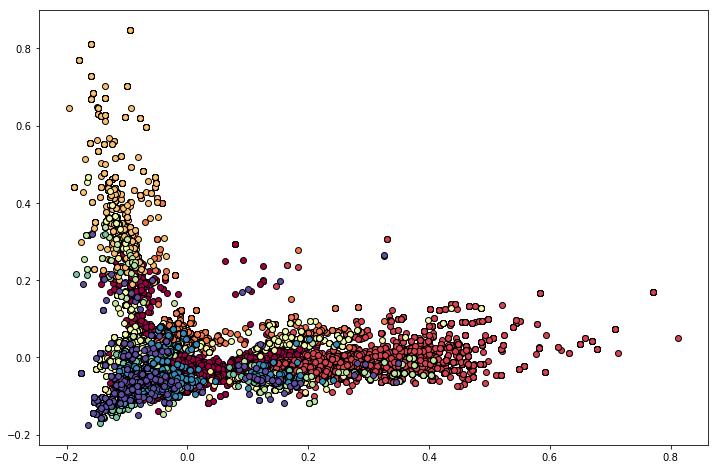

In [10]:
#Project the data onto 2D space and plot

import matplotlib.pyplot as plt

pca_decomposer = PCA(2)
TWODTFIDF = pca_decomposer.fit_transform(TFIDF.todense())

unique_labels = set(KMEANS)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(12,8))
for k, col in zip(unique_labels, colors):

    class_member_mask = (KMEANS == k)

    xy = TWODTFIDF[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.show()

In [11]:
#Create features as binary flags that represent cluster membership

features = pd.DataFrame()
features['cluster'] = KMEANS
features['c0'] = features['cluster'].map(lambda x: 1 if x == 0 else 0)
features['c1'] = features['cluster'].map(lambda x: 1 if x == 1 else 0)
features['c2'] = features['cluster'].map(lambda x: 1 if x == 2 else 0)
features['c3'] = features['cluster'].map(lambda x: 1 if x == 3 else 0)
features['c4'] = features['cluster'].map(lambda x: 1 if x == 4 else 0)
features['c5'] = features['cluster'].map(lambda x: 1 if x == 5 else 0)
features['c6'] = features['cluster'].map(lambda x: 1 if x == 6 else 0)
features['c7'] = features['cluster'].map(lambda x: 1 if x == 7 else 0)
features['c8'] = features['cluster'].map(lambda x: 1 if x == 8 else 0)
features['c9'] = features['cluster'].map(lambda x: 1 if x == 9 else 0)

In [12]:
#Create linear regression model of cluster predicting nfin

lr = LinearRegression(fit_intercept=False)
_ = lr.fit(features[['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']], df['nfin'])

In [13]:
#Print cluster coefs

for i in range(10):
    print 'c%d\t% f' % (i, lr.coef_[i])

c0	 0.037792
c1	-0.259705
c2	 0.088401
c3	 0.067005
c4	 0.066844
c5	 0.038677
c6	 0.058986
c7	 0.215351
c8	-0.248524
c9	-0.043629


In [17]:
#Inspect comments from most negative cluster (Note if you re-train the model, clustering may change 
#slightly, so a different cluster may be the most negative)

df.iloc[features[features.c1 == 1].index][['ndate','trk','meet','race','nfin','com']]

,ndate,trk,meet,race,nfin,com
14,20180301,DB,A,2,-0.357143,SHFFLD BK BLKD 1ST
22,20180301,DB,A,3,-0.357143,COLLIDED WIDE 1ST
23,20180301,DB,A,3,-0.500000,COLLIDED BLKD 1ST
29,20180301,DB,A,4,-0.214286,BLOCKED WIDE 1ST
30,20180301,DB,A,4,-0.357143,PNCHD BK BLKD 1ST
31,20180301,DB,A,4,-0.500000,BLOCKED WIDE 1ST
38,20180301,DB,A,5,-0.357143,CRWD ERLY BLKD 1ST
39,20180301,DB,A,5,-0.500000,CRWD ERLY BLKD 1ST
46,20180301,DB,A,6,-0.357143,CRWD ERLY BLKD 1ST
47,20180301,DB,A,6,-0.500000,CRWD ERLY BLKD 1ST


In [16]:
#Inspect comments from most positive cluster (Note if you re-train the model, clustering may change 
#slightly, so a different cluster may be the most positive)

df.iloc[features[features.c7 == 1].index][['ndate','trk','meet','race','nfin','com']]

,ndate,trk,meet,race,nfin,com
149,20180301,MG,A,6,0.500000,BOX TO WIRE OUTSIDE
173,20180301,MG,A,9,0.500000,BOX TO WIRE INSIDE
256,20180301,NF,A,1,-0.214286,FAILED TO ADVANCE OUTS
264,20180301,NF,A,2,-0.214286,FAILED TO IMPROVE MID
280,20180301,NF,A,4,-0.214286,FAILED TO RESPOND INS
287,20180301,NF,A,5,-0.071429,FAILED TO ADVANCE OUTS
295,20180301,NF,A,6,-0.071429,FAILED TO ADVANCE MID
304,20180301,NF,A,7,-0.214286,FAILED TO RESPOND INS
327,20180301,NF,T,2,-0.071429,FAILED TO ADVANCE OUTS
335,20180301,NF,T,3,-0.071429,FAILED TO FIRE INS
